## ✅ Résumé clair du projet

### 🎯 Objectif

Construire un modèle de **CCF Forward Looking (FL)** pour enrichir le calcul de l’**EAD** dans le cadre IFRS 9, en tenant compte des variables **macroéconomiques** et du **cycle de crédit**.
👉 Le but est de projeter un **CCF prévisionnel à 3 ans** à partir d’observations historiques et de données macro.

---

## 🧭 Étapes de travail recommandées (en Python)

### 1. 🔧 **Préparation des données**

* Charger les séries annuelles de CCF **observées (PiT)** par segment (dans Excel ou CSV)
* Charger les **CCF TTC (Through The Cycle)** servant de point d’ancrage
* Récupérer les séries **macro INSEE** (voir page 13 du PDF) :

  * PIB
  * Inflation
  * Chômage
  * Prix du logement

### 2. 📊 **Analyse exploratoire**

* Étudier la **stationnarité** des séries : `adfuller()` de `statsmodels`
* Visualiser les corrélations entre CCF et les variables macro (`heatmap`, `corr()`)
* Lisser éventuellement les séries via moyennes mobiles

### 3. 📈 **Modélisation**

Deux approches possibles :

#### A. Régression économique

> `CCF_PIT ~ macro_var1 + macro_var2 + …`

* Régression linéaire (`LinearRegression`)
* Ridge / Lasso pour éviter le sur-apprentissage
* Option : utiliser `statsmodels.OLS()` pour avoir les p-values

#### B. Approche hybride TTC + FL

> `CCF_proj = CCF_TTC + impact_macro`

* Calculer l’écart entre CCF\_PIT et CCF\_TTC (Δ)
* Modéliser Δ avec les variables macroéconomiques
* Ajouter la prévision de Δ au CCF\_TTC pour obtenir le CCF prévisionnel

---

### 4. 📉 **Projection**

* Créer un modèle `predict(X_macro_future)` pour les 3 prochaines années
* Appliquer le modèle sur des **scénarios macro projetés**
* Plafonner les valeurs à 100% (page 11)

---

### 5. 📁 Livrables attendus

* Un `main.py` exécutable
* Un `notebook` exploratoire
* Un fichier `ccf_model.py` avec la logique de modélisation
* Une **synthèse claire** (PDF, 3-4 pages) :

  * Hypothèses
  * Données utilisées
  * Modèles testés
  * Résultats / projections



### 📁 **Données\_CFF\_SERIE\_GLOBALE\_VF.csv**

| Variable               | Description                                                                                              | Remarque                                                                                                           |
| ---------------------- | -------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------ |
| `date`                 | Date d’arrêté. Correspond à la génération 12 mois avant le défaut                                        | Les données sont trimestrielles. Tester aussi une modélisation annuelle, comme c’est le cas en production bancaire |
| `Indicateur_Moyen_1_5` | CCF brut moyen trimestriel pour la population des segments 1 à 5 (où le CCF est variable)                | Variable cible à projeter                                                                                          |
| `Effectif_Pourc_1_5`   | % d’effectifs pour une date donnée (segments 1 à 5)                                                      | Sert à pondérer les périodes, utile pour améliorer la corrélation avec les variables macro                         |
| `Indicateur_Moyen_1_6` | CCF brut moyen trimestriel pour l’ensemble de la population (incluant le segment 6 avec CCF fixé à 100%) | Variable cible à projeter                                                                                          |
| `Effectif_Pourc_1_6`   | % d’effectifs pour une date donnée (segments 1 à 6)                                                      | Sert à pondérer les périodes et tester l’apport du segment 6 malgré son CCF fixe                                   |

---

### 📁 **Données\_CFF\_PAR\_SEGMENT.csv**

| Variable                | Description                                                                       | Remarque                                                                                                                       |
| ----------------------- | --------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------ |
| `Date`                  | Date d’arrêté (de 200903 à 202212)                                                | Tester modélisation trimestrielle **et** annuelle                                                                              |
| `Note_ref`              | Segment du CCF                                                                    | —                                                                                                                              |
| `Indicateur_moyen_Brut` | CCF moyen brut par segment                                                        | Variable cible                                                                                                                 |
| `PourcNote`             | % de la population d’un segment par rapport à l’ensemble des trimestres existants | Peu utile au début, mais à tester pour analyse de stationnarité                                                                |
| `PourcNoteCohorte`      | % dans un segment par rapport à toute la cohorte (6 segments)                     | Séries souvent instables, peut fausser les analyses. À tester avec pondération par les effectifs (ex : Weighted Least Squares) |
| `PourcNoteCohorte5`     | % dans un segment par rapport à la cohorte 1 à 5 (exclut segment 6 à CCF fixe)    | À privilégier pour éviter la distorsion induite par le segment 6                                                               |



# CHARGER LES DONNES

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot


In [136]:
# Chargement des données
segment_path = '/Users/toninrvr/Documents/MOSEF venv/Credit-Risk-Project/data/Données_CCF_PAR_SEGMENT.csv'
global_path = '/Users/toninrvr/Documents/MOSEF venv/Credit-Risk-Project/data/Données_CCF_SERIE_GLOBALE_VF.csv'

df_global = pd.read_csv(global_path, sep=";")
df_segment = pd.read_csv(segment_path, sep=";")

# Statistiques descriptives
desc_global = df_global.info()
desc_segment = df_segment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   date                  60 non-null     object
 1   Indicateur_Moyen_1_5  60 non-null     object
 2   Effectif_Pourc_1_5    60 non-null     object
 3   Indicateur_Moyen_1_6  56 non-null     object
 4   Effectif_Pourc_1_6    56 non-null     object
dtypes: object(5)
memory usage: 2.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   cod_prd_ref            360 non-null    object
 1   note_ref               360 non-null    int64 
 2   Indicateur_moyen_Brut  360 non-null    object
 3   PourcNote              360 non-null    object
 4   PourcNoteCohorte       360 non-null    object
 5   PourcNoteCohorte5      360 non-null    obj

In [137]:
macro_path = '/Users/toninrvr/Documents/MOSEF venv/Credit-Risk-Project/data/macrovariables/historique_macro_variables_projet_CCF_FowardLooking_IFRS9.xlsx'
df_macro = pd.read_excel(macro_path)

print(df_macro.head())

  date_dernier_mois  PIB  IPL  TCH  Inflation  PIB_diff1  IPL_diff1  \
0           1980-03  0.0  0.0  5.3        0.0        NaN        NaN   
1           1980-06  0.0  0.0  5.3        0.0        0.0        0.0   
2           1980-09  0.0  0.0  5.4        0.0        0.0        0.0   
3           1980-12  0.0  0.0  5.6        0.0        0.0        0.0   
4           1981-03  0.0  0.0  6.0        0.0        0.0        0.0   

   TCH_diff1  Inflation_diff1  
0        NaN              NaN  
1        0.0              0.0  
2        0.1              0.0  
3        0.2              0.0  
4        0.4              0.0  


# EXPLO DES DONNEES

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# Nettoyage et conversion des colonnes numériques avec virgules
for col in ['Indicateur_Moyen_1_5', 'Effectif_Pourc_1_5', 'Indicateur_Moyen_1_6', 'Effectif_Pourc_1_6']:
    df_global[col] = df_global[col].str.replace(',', '.').astype(float)

for col in ['Indicateur_moyen_Brut', 'PourcNote', 'PourcNoteCohorte', 'PourcNoteCohorte5']:
    df_segment[col] = df_segment[col].str.replace(',', '.').astype(float)

# Conversion des dates
df_global['date'] = pd.to_datetime(df_global['date'])

# Nettoyage des espaces et conversion en date trimestrielle
df_segment['date'] = pd.to_datetime(df_segment['cod_prd_ref'].str.strip().str.replace('T', 'Q'))

# Affichage des dates uniques triées pour vérification
df_segment['date'].sort_values().unique()

# Statistiques descriptives
desc_global = df_global.describe()
desc_segment = df_segment.describe()

print(desc_global)
print("----")
print(desc_segment)

                      date  Indicateur_Moyen_1_5  Effectif_Pourc_1_5  \
count                   60             60.000000           60.000000   
mean   2016-01-05 21:36:00              0.710161            0.016667   
min    2009-01-01 00:00:00              0.475551            0.008257   
25%    2012-01-09 06:00:00              0.607004            0.012825   
50%    2016-01-05 12:00:00              0.690971            0.016108   
75%    2020-01-01 18:00:00              0.820344            0.021441   
max    2023-01-10 00:00:00              0.970606            0.024525   
std                    NaN              0.123135            0.004892   

       Indicateur_Moyen_1_6  Effectif_Pourc_1_6  
count             56.000000           56.000000  
mean               0.863108            0.017857  
min                0.749491            0.009202  
25%                0.825782            0.014296  
50%                0.856909            0.017892  
75%                0.910321            0.021149  
m

/var/folders/f0/q3pz9yqx3x7gnp3hqnj1hqvm0000gn/T/ipykernel_2058/3820830927.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_segment['date'] = pd.to_datetime(df_segment['cod_prd_ref'].str.strip().str.replace('T', 'Q'))


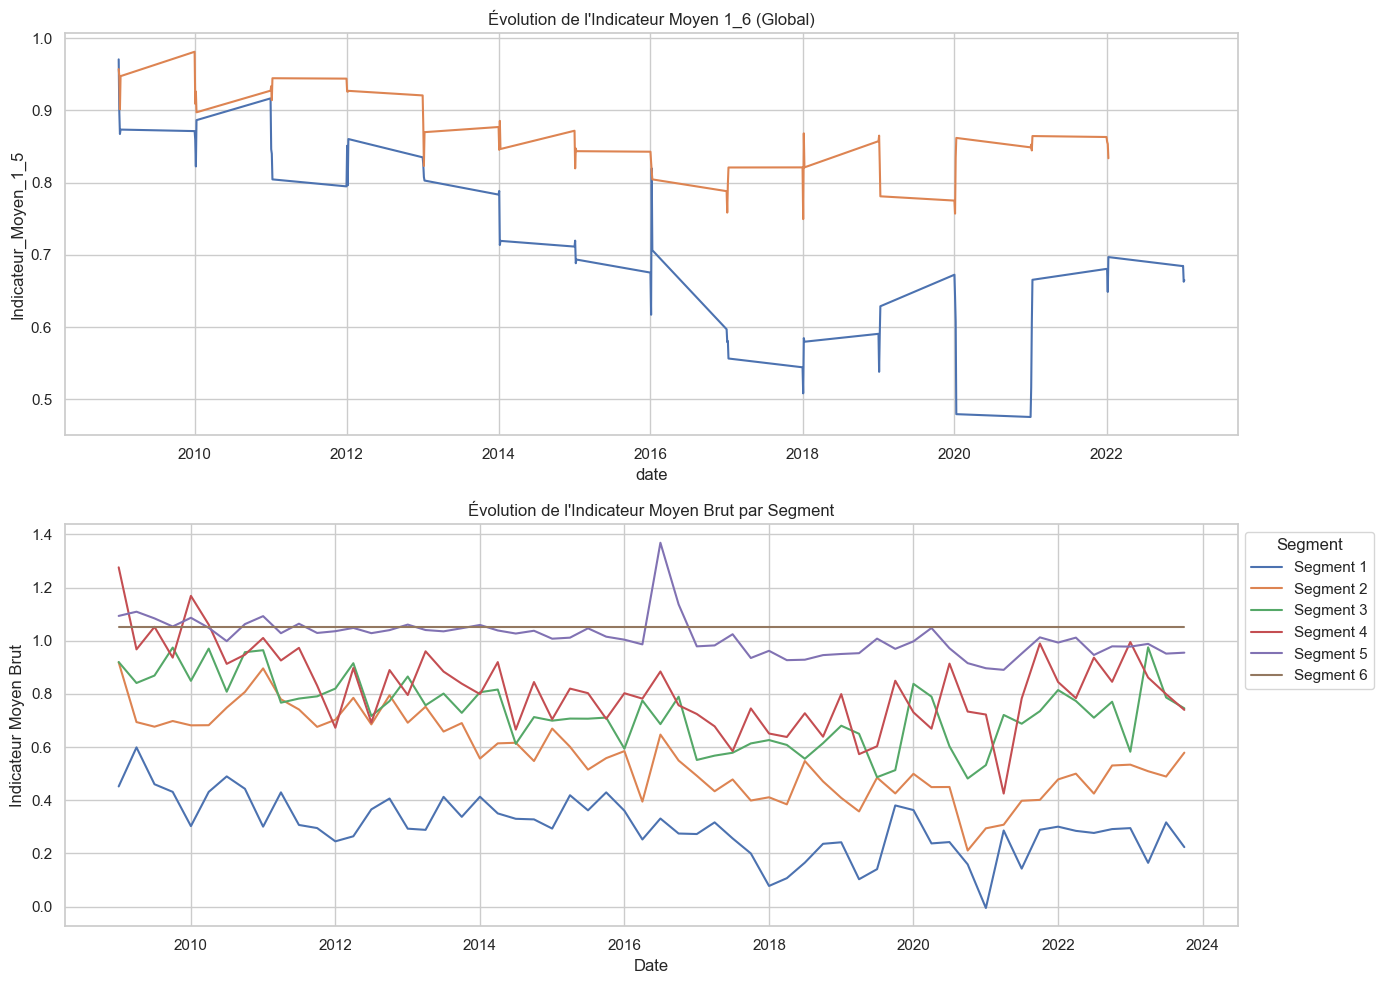

In [139]:
# Visualisations
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=False)

# Global CCF 1_5
sns.lineplot(data=df_global, x='date', y='Indicateur_Moyen_1_5', ax=axs[0])
axs[0].set_title("Évolution de l'Indicateur Moyen 1_5 (Global)")

sns.lineplot(data=df_global, x='date', y='Indicateur_Moyen_1_6', ax=axs[0])
axs[0].set_title("Évolution de l'Indicateur Moyen 1_6 (Global)")


# Plusieurs segments superposés avec légende
for i in range(0, 6):
    segment = df_segment['note_ref'].unique()[i]
    df_plot_seg = df_segment[df_segment['note_ref'] == segment]
    sns.lineplot(
        data=df_plot_seg,
        x='date',
        y='Indicateur_moyen_Brut',
        ax=axs[1],
        label=f"Segment {segment}"
    )

axs[1].set_title("Évolution de l'Indicateur Moyen Brut par Segment")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Indicateur Moyen Brut")
axs[1].legend(title="Segment", loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()



#### DONNEES INSEE

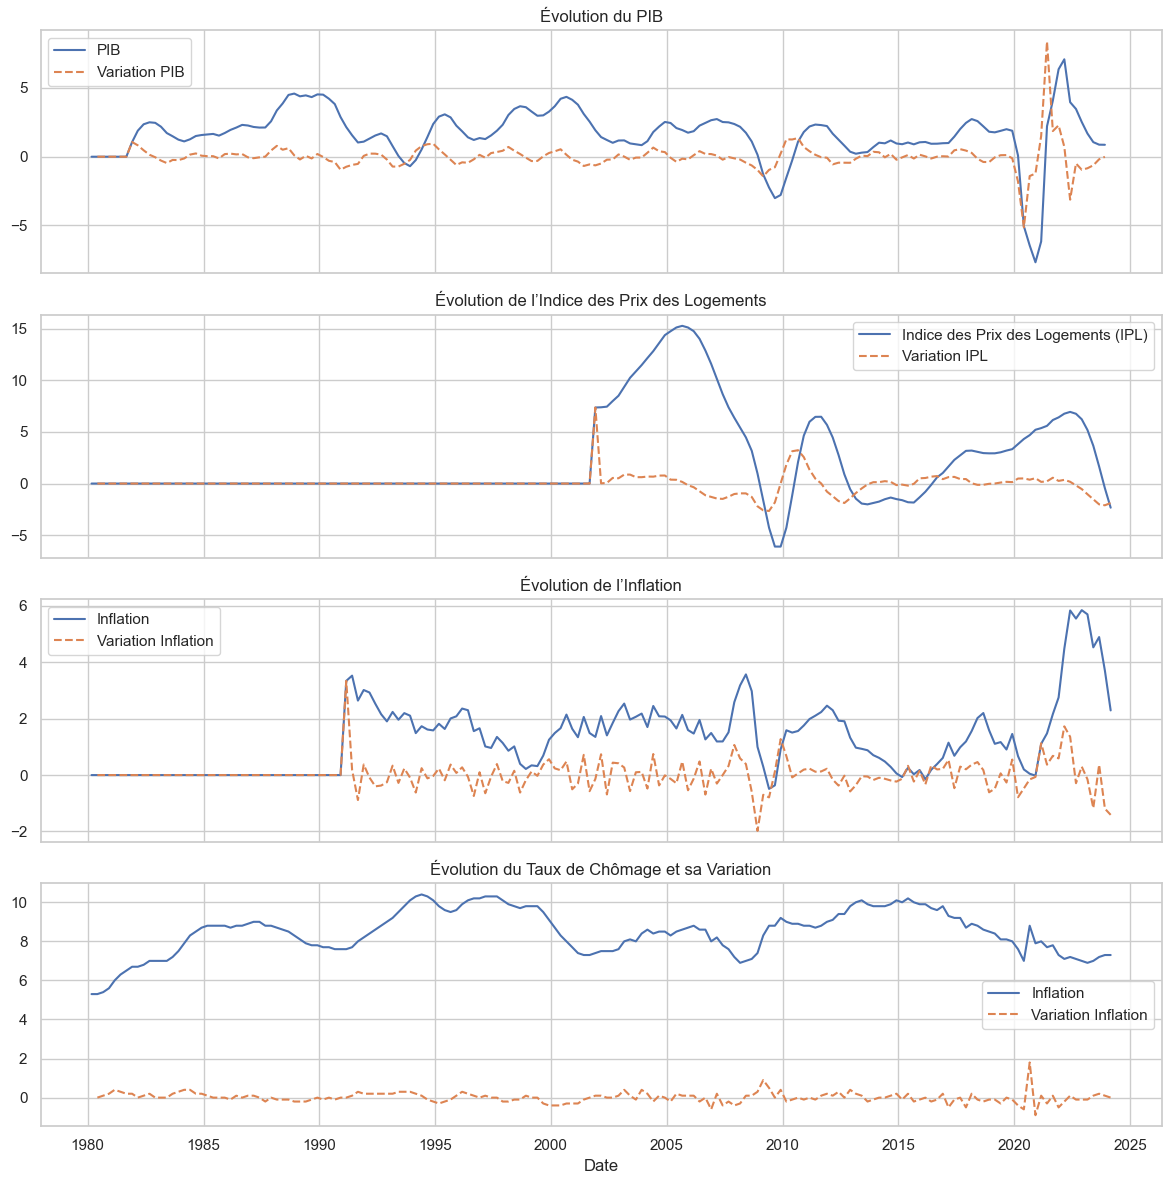

In [140]:
# Tracer PIB, IPL et Inflation avec leurs variations
fig, ax = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

df_macro["date_dernier_mois"] = pd.to_datetime(df_macro["date_dernier_mois"])

# PIB
ax[0].plot(df_macro["date_dernier_mois"], df_macro["PIB"], label="PIB")
ax[0].plot(df_macro["date_dernier_mois"], df_macro["PIB_diff1"], label="Variation PIB", linestyle='--')
ax[0].set_title("Évolution du PIB")
ax[0].legend()
ax[0].grid(True)

# IPL
ax[1].plot(df_macro["date_dernier_mois"], df_macro["IPL"], label="Indice des Prix des Logements (IPL)" )
ax[1].plot(df_macro["date_dernier_mois"], df_macro["IPL_diff1"], label="Variation IPL", linestyle='--')
ax[1].set_title("Évolution de l’Indice des Prix des Logements")
ax[1].legend()
ax[1].grid(True)

# Inflation
ax[2].plot(df_macro["date_dernier_mois"], df_macro["Inflation"], label="Inflation")
ax[2].plot(df_macro["date_dernier_mois"], df_macro["Inflation_diff1"], label="Variation Inflation", linestyle='--')
ax[2].set_title("Évolution de l’Inflation")
ax[2].legend()
ax[2].grid(True)

# Inflation
ax[3].plot(df_macro["date_dernier_mois"], df_macro["TCH"], label="Inflation")
ax[3].plot(df_macro["date_dernier_mois"], df_macro["TCH_diff1"], label="Variation Inflation", linestyle='--')
ax[3].set_title("Évolution du Taux de Chômage et sa Variation")
ax[3].legend()
ax[3].grid(True)

plt.xlabel("Date")
plt.tight_layout()
plt.show()


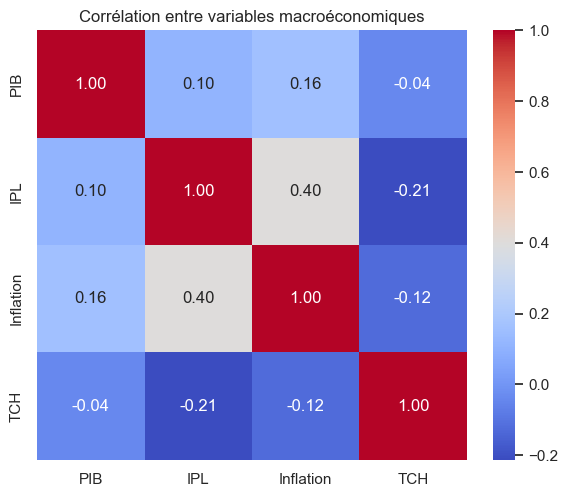

In [141]:
# Corrélation simple entre les 4 variables macro (en niveau)
simple_corr = df_macro[["PIB", "IPL", "Inflation", "TCH"]].corr()

# Tracer la heatmap de corrélation
plt.figure(figsize=(6, 5))
sns.heatmap(simple_corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Corrélation entre variables macroéconomiques")
plt.tight_layout()
plt.show()


In [142]:
print(df_macro.head())

  date_dernier_mois  PIB  IPL  TCH  Inflation  PIB_diff1  IPL_diff1  \
0        1980-03-01  0.0  0.0  5.3        0.0        NaN        NaN   
1        1980-06-01  0.0  0.0  5.3        0.0        0.0        0.0   
2        1980-09-01  0.0  0.0  5.4        0.0        0.0        0.0   
3        1980-12-01  0.0  0.0  5.6        0.0        0.0        0.0   
4        1981-03-01  0.0  0.0  6.0        0.0        0.0        0.0   

   TCH_diff1  Inflation_diff1  
0        NaN              NaN  
1        0.0              0.0  
2        0.1              0.0  
3        0.2              0.0  
4        0.4              0.0  


## FORMATAGE

##### Mise à jour des dates 

In [143]:
# Créer une fonction de conversion fin → début de trimestre
def start_of_quarter(date):
    if date.month == 3:
        return pd.Timestamp(year=date.year, month=1, day=1)
    elif date.month == 6:
        return pd.Timestamp(year=date.year, month=4, day=1)
    elif date.month == 9:
        return pd.Timestamp(year=date.year, month=7, day=1)
    elif date.month == 12:
        return pd.Timestamp(year=date.year, month=10, day=1)
    else:
        return pd.NaT

# S'assurer que la colonne est au format datetime
df_macro["date_dernier_mois"] = pd.to_datetime(df_macro["date_dernier_mois"], errors='coerce')

# Appliquer la transformation sur df_macro
df_macro["date_dernier_mois"] = df_macro["date_dernier_mois"].apply(start_of_quarter)


In [144]:
# Reformatage : d'abord en string inversé, puis en datetime
df_macro["date_dernier_mois"] = df_macro["date_dernier_mois"].dt.strftime("%d-%m-%Y")
df_macro["date_dernier_mois"] = pd.to_datetime(df_macro["date_dernier_mois"], format="%m-%d-%Y")

# Filtrer les dates de l'année 2009 pour les deux DataFrames
dates_segment_2009 = df_segment[df_segment["date"].dt.year == 2009]["date"].unique()
dates_global_2009 = df_global[df_global["date"].dt.year == 2009]["date"].unique()
dates_macro_2009 = df_macro[df_macro["date_dernier_mois"].dt.year == 2009]["date_dernier_mois"].unique()

# Créer un tableau comparatif
df_dates_2009 = pd.DataFrame({
    "Dates df_global (2009)": dates_global_2009,
    "Dates df_segment (2009)": dates_segment_2009,
    "Dates df_macro (2009)": dates_macro_2009
})

print(df_dates_2009)



  Dates df_global (2009) Dates df_segment (2009) Dates df_macro (2009)
0             2009-01-01              2009-01-01            2009-01-01
1             2009-01-04              2009-04-01            2009-01-04
2             2009-01-07              2009-07-01            2009-01-07
3             2009-01-10              2009-10-01            2009-01-10


##### Segmenter les DF

In [145]:
# Créer un DataFrame par segment (valeur unique de note_ref)
segments_dfs = {
    f"segment_{segment}": df_segment[df_segment["note_ref"] == segment].reset_index(drop=True)
    for segment in sorted(df_segment["note_ref"].unique())
}

# Afficher les noms des segments et un aperçu d’un segment
segment_names = list(segments_dfs.keys())

segment_1 = segments_dfs[segment_names[0]]
segment_2 = segments_dfs[segment_names[1]]
segment_3 = segments_dfs[segment_names[2]]
segment_4 = segments_dfs[segment_names[3]]
segment_5 = segments_dfs[segment_names[4]]
segment_6 = segments_dfs[segment_names[5]]

### Merged avec MACRO 

In [ ]:
# Pivot pour obtenir les colonnes Indicateur_moyen_Brut_1 à 6
pivot_df = df_segment.pivot(index="date", columns="note_ref", values="Indicateur_moyen_Brut")
pivot_df.columns = [f"Indicateur_moyen_Brut_{int(col)}" for col in pivot_df.columns]

df_merged = df_global.merge(pivot_df, on="date")

df_merged = df_merged.merge(df_macro, left_on="date", right_on="date_dernier_mois", how="left")
df_merged.drop(columns=["date_dernier_mois", "Effectif_Pourc_1_5", "Effectif_Pourc_1_6"], inplace=True)

df_merged_6 = df_merged.copy()

df_merged.drop(columns=["Indicateur_Moyen_1_6", "Indicateur_moyen_Brut_6"], inplace=True)

print(df_merged.head())


        date  Indicateur_Moyen_1_5  Indicateur_moyen_Brut_1  \
0 2009-01-01              0.970606                 0.451963   
1 2010-01-01              0.871323                 0.302710   
2 2011-01-01              0.916627                 0.300743   
3 2012-01-01              0.794789                 0.245487   
4 2013-01-01              0.835020                 0.293111   

   Indicateur_moyen_Brut_2  Indicateur_moyen_Brut_3  Indicateur_moyen_Brut_4  \
0                 0.918515                 0.919843                 1.275864   
1                 0.681718                 0.849149                 1.168515   
2                 0.895860                 0.964282                 1.010295   
3                 0.702698                 0.819873                 0.672708   
4                 0.691577                 0.865334                 0.795765   

   Indicateur_moyen_Brut_5       PIB       IPL   TCH  Inflation  PIB_diff1  \
0                 1.093203 -1.286788 -1.624415   8.3   0.30169

## ANALYSE

### GLOBAL

#### Autocorrelation

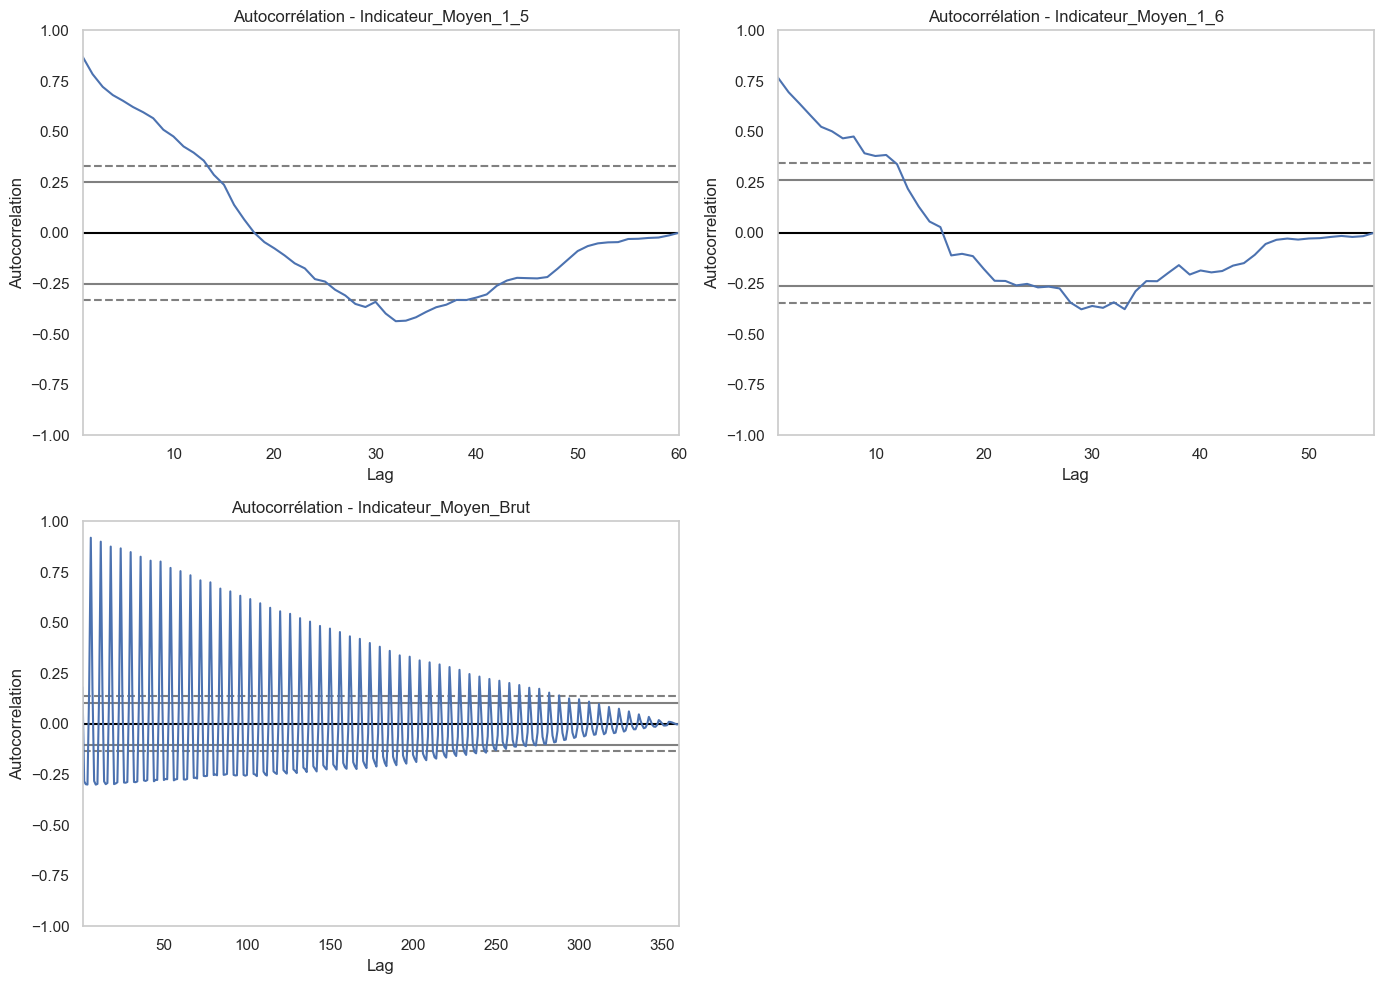

In [49]:
# Tracer les autocorrélations
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
autocorrelation_plot(df_global["Indicateur_Moyen_1_5"].dropna())
plt.title("Autocorrélation - Indicateur_Moyen_1_5")

plt.subplot(2, 2, 2)
autocorrelation_plot(df_global["Indicateur_Moyen_1_6"].dropna())
plt.title("Autocorrélation - Indicateur_Moyen_1_6")

plt.subplot(2, 2, 3)
autocorrelation_plot(df_segment["Indicateur_moyen_Brut"].dropna())
plt.title("Autocorrélation - Indicateur_Moyen_Brut")


plt.tight_layout()
plt.show()

#### Stationnarité

In [50]:
# Appliquer les tests ADF en utilisant les bons DataFrames pour chaque série

# Création de dictionnaires d'entrée
series_sources = {
    "Indicateur_Moyen_1_5": df_global["Indicateur_Moyen_1_5"].dropna(),  # df_global
    "Indicateur_Moyen_1_6": df_global["Indicateur_Moyen_1_6"].dropna(),  # df_global
    "Indicateur_Moyen_Brut": df_segment["Indicateur_moyen_Brut"].dropna()  # df_segmentdf_segment["Indicateur_moyen_Brut"].dropna() df_segment["Indicateur_moyen_Brut"].dropna()  #  # df_segment
}
# Lancer le test ADF
adf_results_corrected = []

for name, series in series_sources.items():
    adf = adfuller(series)
    adf_results_corrected.append({
        "Série": name,
        "ADF Statistic": adf[0],
        "p-value": adf[1],
        "Critique 1%": adf[4]['1%'],
        "Critique 5%": adf[4]['5%'],
        "Critique 10%": adf[4]['10%']
    })

adf_df_corrected = pd.DataFrame(adf_results_corrected)
adf_df_corrected

,Série,ADF Statistic,p-value,Critique 1%,Critique 5%,Critique 10%
0,Indicateur_Moyen_1_5,-2.371826,0.149847,-3.546395,-2.911939,-2.593652
1,Indicateur_Moyen_1_6,-2.128698,0.233133,-3.557709,-2.916770,-2.596222
2,Indicateur_Moyen_Brut,-2.053515,0.263612,-3.449616,-2.870028,-2.571292


#### Règles de stationnarité

p-value > 0.05, donc on ne rejette pas l’hypothèse nulle :


👉 pas stationnaire au seuil de 5%.


Statistique ADF > valeur critique à 5%,

👉 pas stationnaire au seuil de 5%.

### Par segment

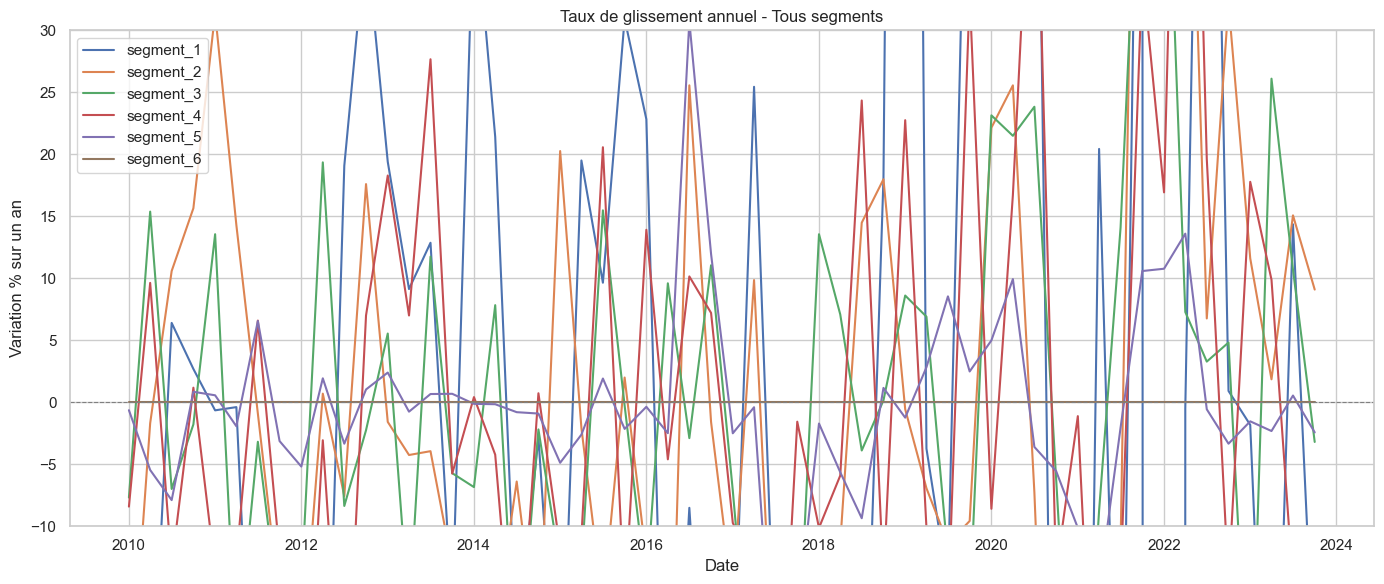

In [ ]:
# Réimporter bibliothèques nécessaires après reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calcul du glissement annuel pour tous les segments
glissement_annuel_dfs = {}
for name, df in segments_dfs.items():
    df_sorted = df.sort_values("date").reset_index(drop=True).copy()
    df_sorted["glissement_annuel"] = (df_sorted["Indicateur_moyen_Brut"] / df_sorted["Indicateur_moyen_Brut"].shift(4) - 1) * 100
    glissement_annuel_dfs[name] = df_sorted.dropna().reset_index(drop=True)

# Tracer toutes les séries de glissement annuel sur une seule grille
plt.figure(figsize=(14, 6))
for name, df in glissement_annuel_dfs.items():
    plt.plot(df["date"], df["glissement_annuel"], label=name)

plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.title("Taux de glissement annuel - Tous segments")
plt.xlabel("Date")
plt.ylabel("Variation % sur un an")
plt.ylim(-10, 30)
plt.legend()
plt.tight_layout()
plt.show()


segment_1 60
segment_2 60
segment_3 60
segment_4 60
segment_5 60
segment_6 60


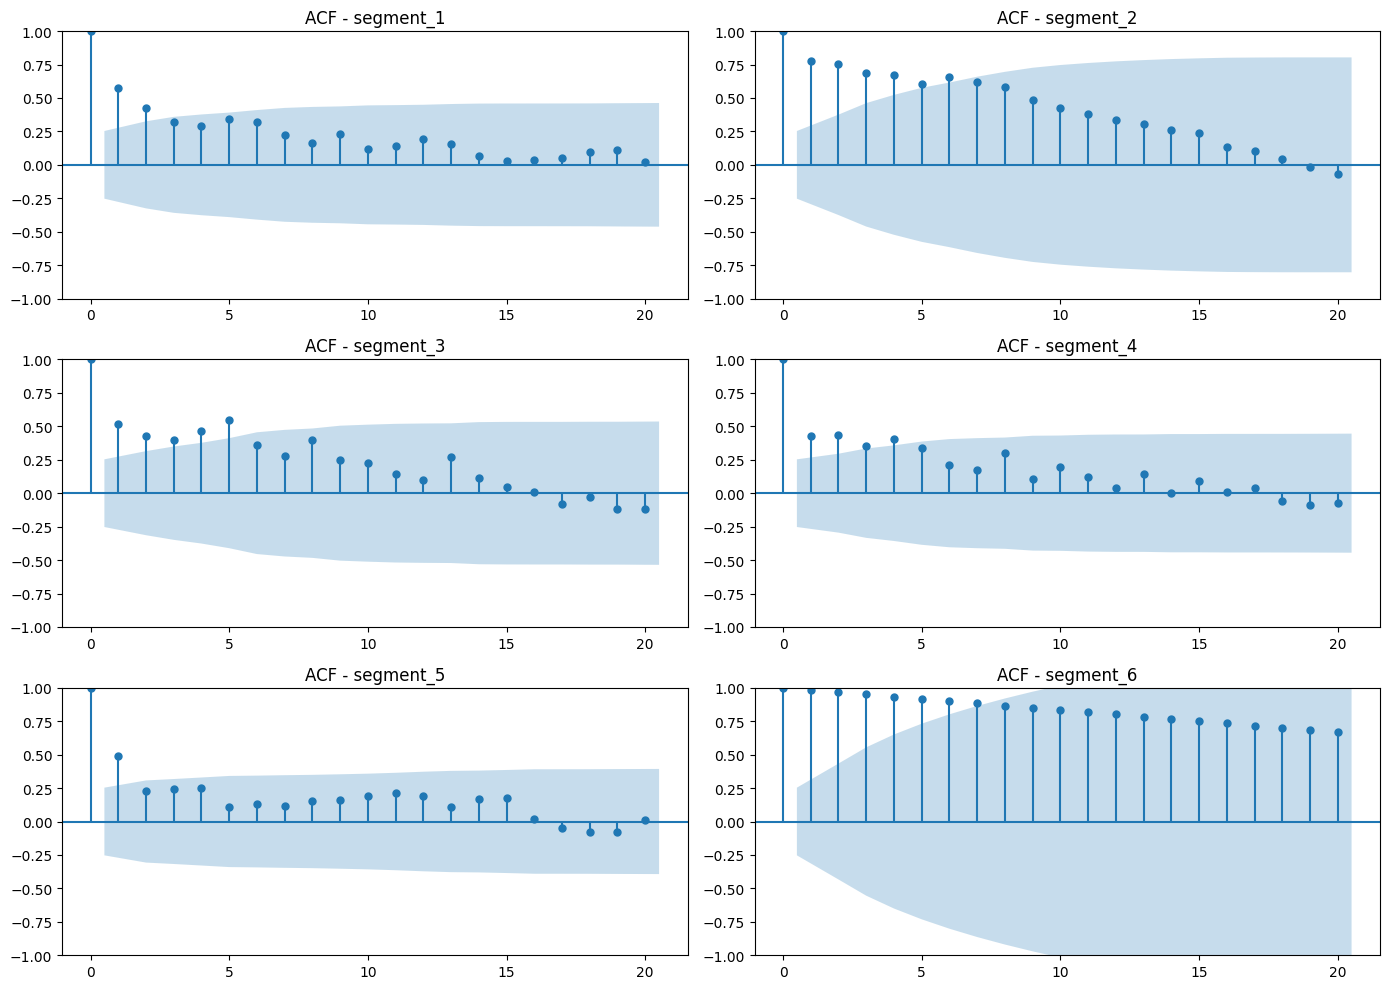

,Segment,ADF Statistic,p-value,Critique 1%,Critique 5%,Critique 10%
0,segment_1,-3.983272,0.001501,-3.546395,-2.911939,-2.593652
1,segment_2,-1.833660,0.363883,-3.548494,-2.912837,-2.594129
2,segment_3,-2.228654,0.196010,-3.565624,-2.920142,-2.598015
3,segment_4,-5.324879,0.000005,-3.546395,-2.911939,-2.593652
4,segment_5,-4.430622,0.000262,-3.546395,-2.911939,-2.593652
5,segment_6,NaN,NaN,NaN,NaN,NaN


In [14]:
# Utiliser segment_names et segments_dfs directement, avec vérification du nombre d'observations

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

# Initialiser résultats
adf_results = []

# Créer la grille de sous-graphiques
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
axes = axes.flatten()
plot_index = 0

for name in segment_names:
    print(name, len(segments_dfs[name]["Indicateur_moyen_Brut"].dropna()))

# Itérer sur les noms de segments existants
for name in segment_names:
    df = segments_dfs[name]
    series = df["Indicateur_moyen_Brut"].dropna()

    # Tester la taille de la série avant de tracer l'ACF
    if len(series) > 20:
        plot_acf(series, ax=axes[plot_index], lags=20, alpha=0.05)
        axes[plot_index].set_title(f"ACF - {name}")
        plot_index += 1

    # Effectuer le test ADF même si la série est courte
    try:
        adf = adfuller(series)
        adf_results.append({
            "Segment": name,
            "ADF Statistic": adf[0],
            "p-value": adf[1],
            "Critique 1%": adf[4]["1%"],
            "Critique 5%": adf[4]["5%"],
            "Critique 10%": adf[4]["10%"]
        })
    except:
        adf_results.append({
            "Segment": name,
            "ADF Statistic": None,
            "p-value": None,
            "Critique 1%": None,
            "Critique 5%": None,
            "Critique 10%": None
        })

# Supprimer les axes inutilisés
for i in range(plot_index, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Créer un tableau des résultats ADF
adf_df = pd.DataFrame(adf_results)
adf_df


| Segment   | ACF persistante | ADF p-value | Stationnaire ? | Action recommandée  |
| --------- | --------------- | ----------- | -------------- | ------------------- |
| Segment 1 | Moyenne         | 0.0015      | ✅ Oui          | OK                  |
| Segment 2 | Forte           | 0.36        | ❌ Non          | Différencier        |
| Segment 3 | Moyenne à forte | 0.196       | ❌ Non          | Différencier        |
| Segment 4 | Moyenne         | 0.000005    | ✅ Oui          | OK                  |
| Segment 5 | Faible          | 0.00026     | ✅ Oui          | OK                  |
| Segment 6 | Très forte      | NaN         | ❓ Invalide     | Vérifier / nettoyer |


## Différenciation

In [15]:
# # Différencier la série temporelle et refaire ADF
# df_global['Indicateur_Moyen_1_5_diff'] = df_global['Indicateur_Moyen_1_5'].diff()

# adf_global = adfuller(df_global['Indicateur_Moyen_1_5_diff'].dropna())
# adf_result = {
#     'ADF Statistic': adf_global[0],
#     'p-value': adf_global[1],
#     'Critical Values': adf_global[4]
# }

# # Résultat du test ADF
# adf_df = pd.DataFrame([adf_result], index=['Indicateur_Moyen_1_5_diff'])
# print("\nRésultat du test ADF:")
# print(adf_df)


### taux de variation

##### Global

In [16]:
# Réimporter les bibliothèques nécessaires après le reset
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Reconstituer les séries simulées (comme dans l'étape précédente)
np.random.seed(42)
dates = pd.date_range(start="2009-01-01", periods=60, freq="Q")
ind_1_5 = np.random.normal(loc=0.71, scale=0.12, size=60)
ind_1_6 = np.random.normal(loc=0.86, scale=0.055, size=60)
ind_bruit = np.cumsum(np.random.normal(loc=0.02, scale=0.05, size=60)) + 0.75

df_autocorr = pd.DataFrame({
    "date": dates,
    "Indicateur_Moyen_1_5": ind_1_5,
    "Indicateur_Moyen_1_6": ind_1_6,
    "Indicateur_Moyen_Brut": ind_bruit
})

# Calcul du taux de variation logarithmique
log_diff_results = {
    "Indicateur_Moyen_1_5": np.log(df_autocorr["Indicateur_Moyen_1_5"]).diff().dropna(),
    "Indicateur_Moyen_1_6": np.log(df_autocorr["Indicateur_Moyen_1_6"]).diff().dropna(),
    "Indicateur_Moyen_Brut": np.log(df_autocorr["Indicateur_Moyen_Brut"]).diff().dropna()
}

# Appliquer le test ADF
adf_logdiff_results = []

for name, series in log_diff_results.items():
    series = series.replace([np.inf, -np.inf], np.nan).dropna()
    adf = adfuller(series)
    adf_logdiff_results.append({
        "Série (log_diff)": name,
        "ADF Statistic": adf[0],
        "p-value": adf[1],
        "Critique 1%": adf[4]['1%'],
        "Critique 5%": adf[4]['5%'],
        "Critique 10%": adf[4]['10%']
    })

df_adf_logdiff = pd.DataFrame(adf_logdiff_results)

display(df_adf_logdiff)


/var/folders/f0/q3pz9yqx3x7gnp3hqnj1hqvm0000gn/T/ipykernel_2058/1021865607.py:8: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(start="2009-01-01", periods=60, freq="Q")


,Série (log_diff),ADF Statistic,p-value,Critique 1%,Critique 5%,Critique 10%
0,Indicateur_Moyen_1_5,-6.907378,1.237275e-09,-3.555273,-2.915731,-2.595670
1,Indicateur_Moyen_1_6,-8.127519,1.112825e-12,-3.555273,-2.915731,-2.595670
2,Indicateur_Moyen_Brut,-10.701609,3.511681e-19,-3.548494,-2.912837,-2.594129


##### Par segment

Avec LOG_DIFF

In [17]:
# Recharger bibliothèques après reset
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Appliquer log.diff() et tester la stationnarité
segments_to_transform = ["segment_2", "segment_3"]
tv_results = []

for name in segments_to_transform:
    series = segments_dfs[name]["Indicateur_moyen_Brut"]
    series_log_diff = np.log(series).diff().dropna()
    
    try:
        adf = adfuller(series_log_diff)
        tv_results.append({
            "Segment (log diff)": name,
            "ADF Statistic": adf[0],
            "p-value": adf[1],
            "Critique 1%": adf[4]['1%'],
            "Critique 5%": adf[4]['5%'],
            "Critique 10%": adf[4]['10%']
        })
    except:
        tv_results.append({
            "Segment (log diff)": name,
            "ADF Statistic": None,
            "p-value": None,
            "Critique 1%": None,
            "Critique 5%": None,
            "Critique 10%": None
        })

df_tv_adf = pd.DataFrame(tv_results)
print(df_tv_adf)

  Segment (log diff)  ADF Statistic   p-value  Critique 1%  Critique 5%  \
0          segment_2      -5.251563  0.000007    -3.557709    -2.916770   
1          segment_3      -2.863254  0.049791    -3.565624    -2.920142   

   Critique 10%  
0     -2.596222  
1     -2.598015  


Avec Hodrick-Prescott

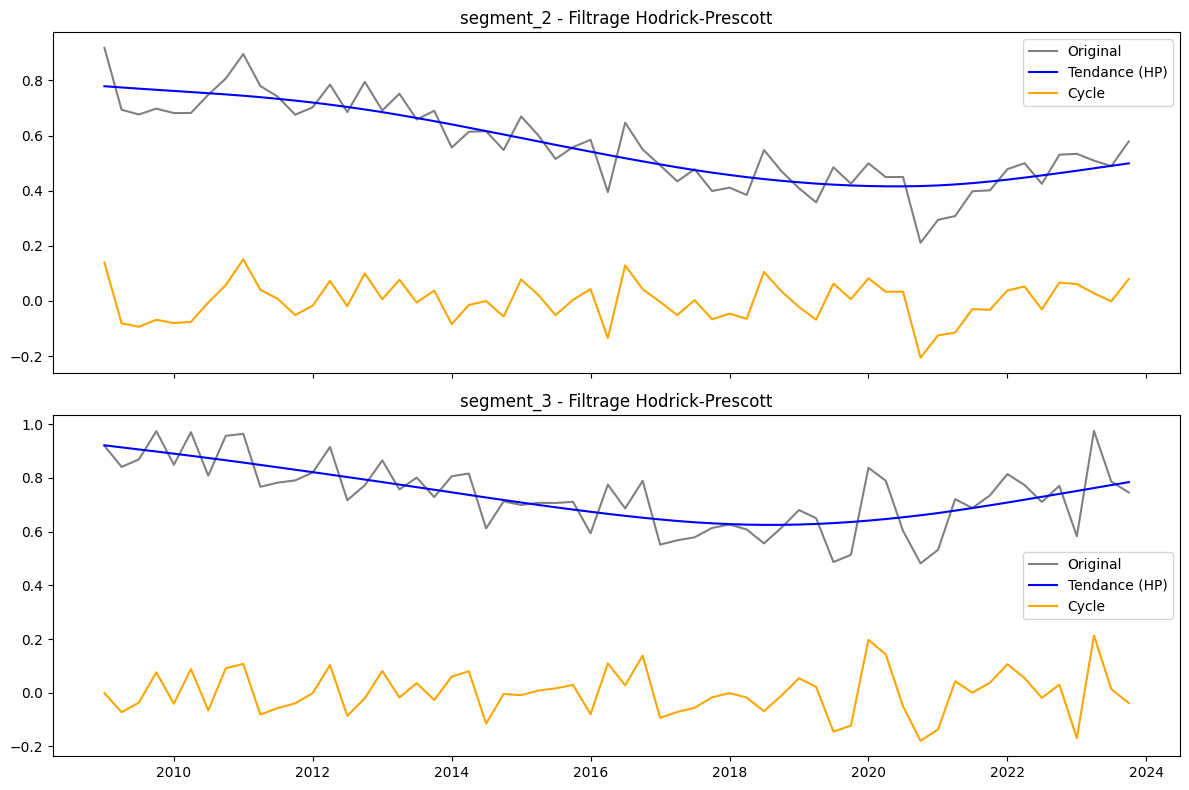

In [18]:
import pandas as pd
import numpy as np
from statsmodels.tsa.filters.hp_filter import hpfilter
import matplotlib.pyplot as plt

# Appliquer le filtre HP à chaque série non stationnaire
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

for i, name in enumerate(["segment_2", "segment_3"]):
    df = segments_dfs[name]
    cycle, trend = hpfilter(df["Indicateur_moyen_Brut"], lamb=1600)
    df["trend"] = trend
    df["cycle"] = cycle

    # Tracer
    axes[i].plot(df["date"], df["Indicateur_moyen_Brut"], label="Original", color='gray')
    axes[i].plot(df["date"], df["trend"], label="Tendance (HP)", color='blue')
    axes[i].plot(df["date"], df["cycle"], label="Cycle", color='orange')
    axes[i].set_title(f"{name} - Filtrage Hodrick-Prescott")
    axes[i].legend()

plt.tight_layout()
plt.show()


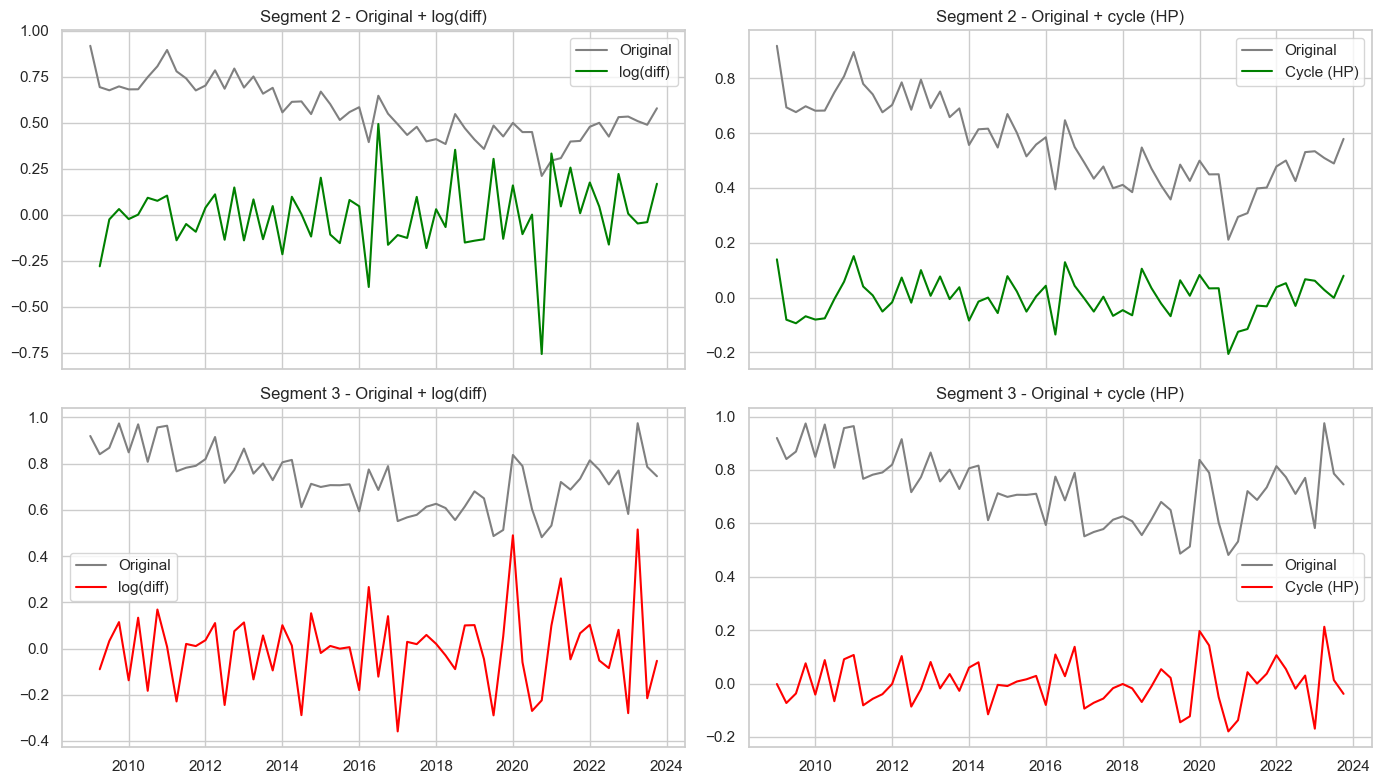

In [22]:
# Recalculer les séries stationnarisées par log.diff() pour segment_2 et segment_3
logdiff_dfs = {}
hp_cycle_dfs = {}

for name in ["segment_2", "segment_3"]:
    df = segments_dfs[name].copy()

    # Méthode log.diff()
    df_logdiff = df[["date", "Indicateur_moyen_Brut"]].copy()
    df_logdiff["log_diff"] = np.log(df_logdiff["Indicateur_moyen_Brut"]).diff()
    logdiff_dfs[name] = df_logdiff.dropna().reset_index(drop=True)

    # Méthode HP filter
    cycle, trend = hpfilter(df["Indicateur_moyen_Brut"], lamb=1600)
    df_hp = df[["date"]].copy()
    df_hp["cycle"] = cycle
    hp_cycle_dfs[name] = df_hp.reset_index(drop=True)

# Ajouter les séries originales à côté des séries stationnarisées pour comparaison visuelle

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)

# Segment 2
axes[0, 0].plot(segments_dfs["segment_2"]["date"], segments_dfs["segment_2"]["Indicateur_moyen_Brut"], label="Original", color="gray")
axes[0, 0].plot(logdiff_dfs["segment_2"]["date"], logdiff_dfs["segment_2"]["log_diff"], label="log(diff)", color="green")
axes[0, 0].set_title("Segment 2 - Original + log(diff)")
axes[0, 0].legend()

axes[0, 1].plot(segments_dfs["segment_2"]["date"], segments_dfs["segment_2"]["Indicateur_moyen_Brut"], label="Original", color="gray")
axes[0, 1].plot(hp_cycle_dfs["segment_2"]["date"], hp_cycle_dfs["segment_2"]["cycle"], label="Cycle (HP)", color="green")
axes[0, 1].set_title("Segment 2 - Original + cycle (HP)")
axes[0, 1].legend()

# Segment 3
axes[1, 0].plot(segments_dfs["segment_3"]["date"], segments_dfs["segment_3"]["Indicateur_moyen_Brut"], label="Original", color="gray")
axes[1, 0].plot(logdiff_dfs["segment_3"]["date"], logdiff_dfs["segment_3"]["log_diff"], label="log(diff)", color="red")
axes[1, 0].set_title("Segment 3 - Original + log(diff)")
axes[1, 0].legend()

axes[1, 1].plot(segments_dfs["segment_3"]["date"], segments_dfs["segment_3"]["Indicateur_moyen_Brut"], label="Original", color="gray")
axes[1, 1].plot(hp_cycle_dfs["segment_3"]["date"], hp_cycle_dfs["segment_3"]["cycle"], label="Cycle (HP)", color="red")
axes[1, 1].set_title("Segment 3 - Original + cycle (HP)")
axes[1, 1].legend()

plt.tight_layout()
plt.show()



| Segment   | Meilleure méthode                                           |
| --------- | ----------------------------------------------------------- |
| Segment 2 | **HP filter** ✅ (plus régulier, moins bruité)               |
| Segment 3 | **log(diff)** ✅ (meilleure réactivité, structure conservée) |


#### Rechecker la stationnarité :

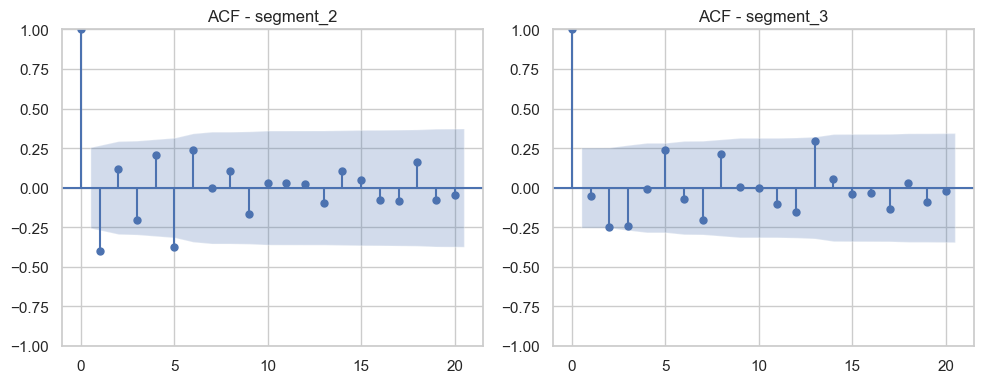

,Segment,ADF Statistic,p-value,Critique 1%,Critique 5%,Critique 10%
0,segment_1,-3.983272,1.500683e-03,-3.546395,-2.911939,-2.593652
1,segment_4,-5.324879,4.861952e-06,-3.546395,-2.911939,-2.593652
2,segment_5,-4.430622,2.619040e-04,-3.546395,-2.911939,-2.593652
3,segment_6,NaN,NaN,NaN,NaN,NaN
4,segment_2,-5.251563,6.893226e-06,-3.557709,-2.916770,-2.596222
5,segment_3,-6.893328,1.338262e-09,-3.550670,-2.913766,-2.594624


In [ ]:
# Recharger les bibliothèques nécessaires
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

# Préparer les séries finales pour ADF et ACF :
# segment_1, segment_4, segment_5, segment_6 → brut
# segment_2 → logdiff
# segment_3 → HP cycle
series_finales = {}

# Segment 2 → log diff
series_finales["segment_2"] = logdiff_dfs["segment_2"]["log_diff"].dropna()

# Segment 3 → HP cycle
series_finales["segment_3"] = hp_cycle_dfs["segment_3"]["cycle"].dropna()

# Calculer ADF et tracer ACF
adf_results = []
fig, axes = plt.subplots(3, 2, figsize=(10, 6))
axes = axes.flatten()

for i, (name, serie) in enumerate(series_finales.items()):
    # ADF test
    try:
        adf = adfuller(serie)
        adf_results.append({
            "Segment": name,
            "ADF Statistic": adf[0],
            "p-value": adf[1],
            "Critique 1%": adf[4]["1%"],
            "Critique 5%": adf[4]["5%"],
            "Critique 10%": adf[4]["10%"]
        })
    except:
        adf_results.append({
            "Segment": name,
            "ADF Statistic": None,
            "p-value": None,
            "Critique 1%": None,
            "Critique 5%": None,
            "Critique 10%": None
        })

    # Plot ACF
    plot_acf(serie, ax=axes[i], lags=20, alpha=0.05)
    axes[i].set_title(f"ACF - {name}")

plt.tight_layout()
plt.show()

display(df_adf_summary)

# Visualisation série après formatage : 

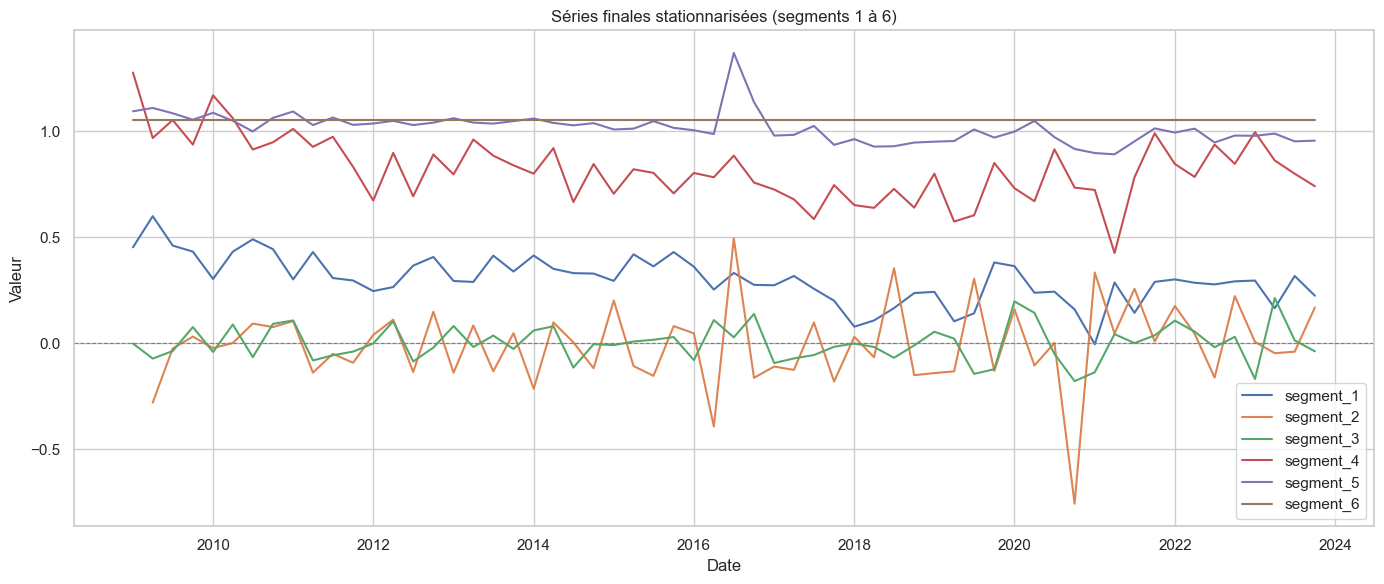

In [63]:
# Recréer les transformations nécessaires pour segment_2 (log diff) et segment_3 (HP cycle)
from statsmodels.tsa.filters.hp_filter import hpfilter

# Log diff pour segment_2
segment_2 = segments_dfs["segment_2"].copy()
logdiff_dfs = {
    "segment_2": segment_2[["date", "Indicateur_moyen_Brut"]].copy()
}
logdiff_dfs["segment_2"]["log_diff"] = np.log(logdiff_dfs["segment_2"]["Indicateur_moyen_Brut"]).diff()

# HP cycle pour segment_3
segment_3 = segments_dfs["segment_3"].copy()
cycle, trend = hpfilter(segment_3["Indicateur_moyen_Brut"], lamb=1600)
hp_cycle_dfs = {
    "segment_3": pd.DataFrame({
        "date": segment_3["date"],
        "cycle": cycle
    })
}

# Recréer series_finales à partir des segments disponibles
series_finales = {
    "segment_1": segments_dfs["segment_1"][["date", "Indicateur_moyen_Brut"]],
    "segment_2": logdiff_dfs["segment_2"][["date", "log_diff"]].rename(columns={"log_diff": "Indicateur_moyen_Brut"}).dropna(),
    "segment_3": hp_cycle_dfs["segment_3"][["date", "cycle"]].rename(columns={"cycle": "Indicateur_moyen_Brut"}),
    "segment_4": segments_dfs["segment_4"][["date", "Indicateur_moyen_Brut"]],
    "segment_5": segments_dfs["segment_5"][["date", "Indicateur_moyen_Brut"]],
    "segment_6": segments_dfs["segment_6"][["date", "Indicateur_moyen_Brut"]],
}

# Tracer toutes les séries sur une même grille
plt.figure(figsize=(14, 6))
for name, df in series_finales.items():
    plt.plot(df["date"], df["Indicateur_moyen_Brut"], label=name)

plt.title("Séries finales stationnarisées (segments 1 à 6)")
plt.xlabel("Date")
plt.ylabel("Valeur")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.legend()
plt.tight_layout()
plt.show()


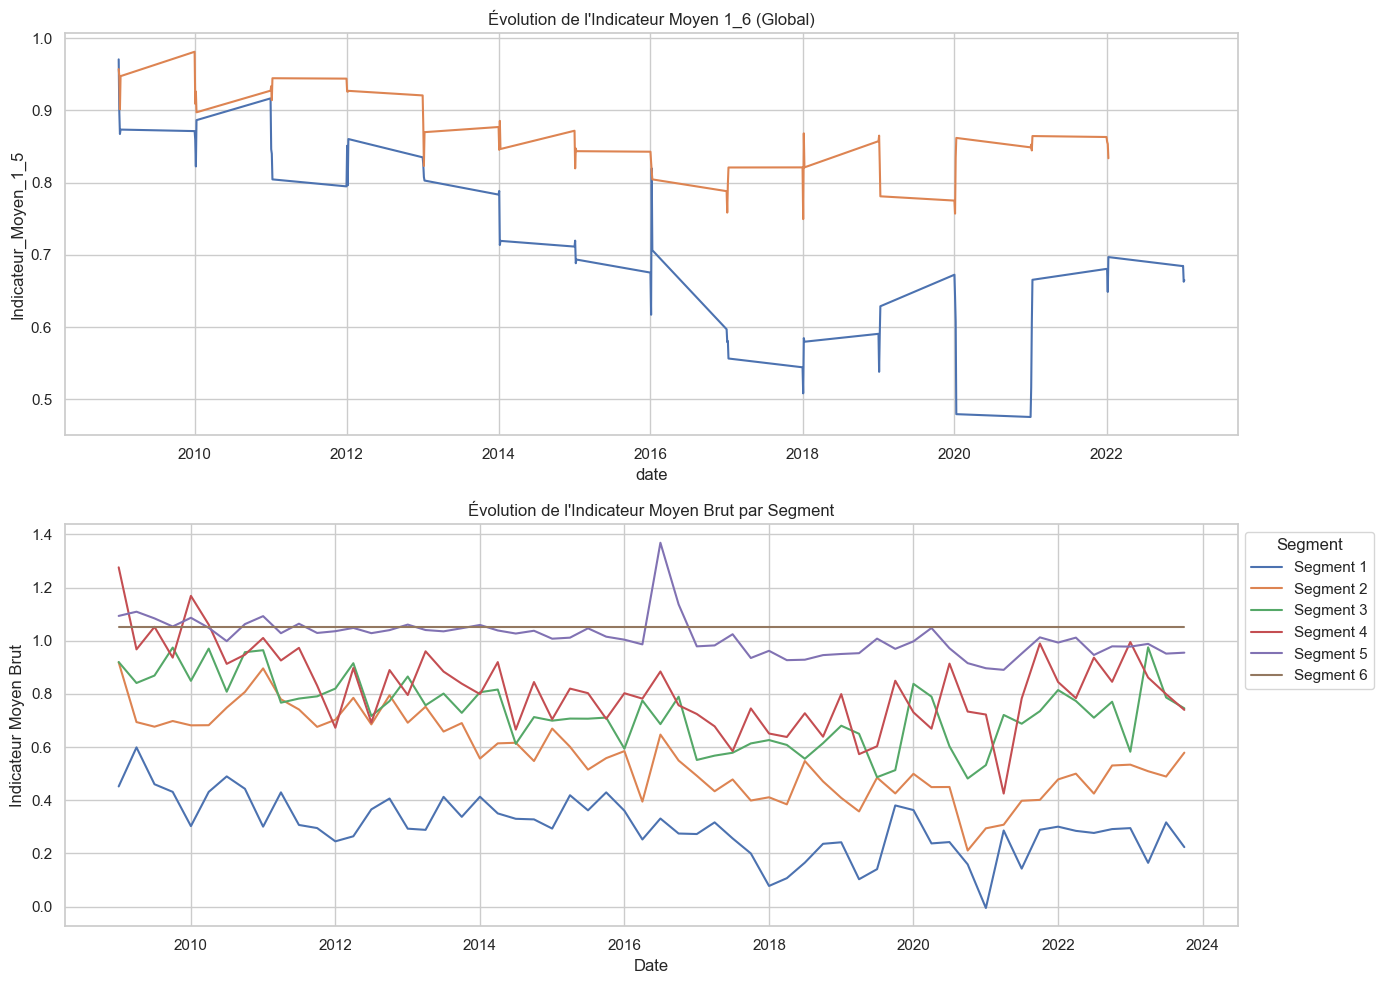

In [ ]:
# Segments avec données brutes
for seg in ["segment_1", "segment_4", "segment_5", "segment_6"]:
    if seg in segments_dfs:
        series_finales[seg] = segments_dfs[seg]["Indicateur_moyen_Brut"].dropna()

# Segment 2 → log diff
series_finales["segment_2"] = logdiff_dfs["segment_2"]["log_diff"].dropna()

# Segment 3 → HP cycle
series_finales["segment_3"] = hp_cycle_dfs["segment_3"]["cycle"].dropna()


# Visualisations
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=False)

# Global CCF 1_5
sns.lineplot(data=df_global, x='date', y='Indicateur_Moyen_1_5', ax=axs[0])
axs[0].set_title("Évolution de l'Indicateur Moyen 1_5 (Global)")

sns.lineplot(data=df_global, x='date', y='Indicateur_Moyen_1_6', ax=axs[0])
axs[0].set_title("Évolution de l'Indicateur Moyen 1_6 (Global)")


# Plusieurs segments superposés avec légende
for i in range(0, 6):
    segment = df_segment['note_ref'].unique()[i]
    df_plot_seg = df_segment[df_segment['note_ref'] == segment]
    sns.lineplot(
        data=df_plot_seg,
        x='date',
        y='Indicateur_moyen_Brut',
        ax=axs[1],
        label=f"Segment {segment}"
    )

axs[1].set_title("Évolution de l'Indicateur Moyen Brut par Segment")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Indicateur Moyen Brut")
axs[1].legend(title="Segment", loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()



## ANALYSE DES SERIES 

In [ ]:
# Calcul de la matrice de corrélation complète
correlation_matrix = df_merged.drop(columns=["date"]).corr()

# Tracer la heatmap de corrélation
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Corrélation entre variables macroéconomiques")
plt.tight_layout()
plt.show()


ValueError: Aucune colonne CCF trouvée dans df_merged.

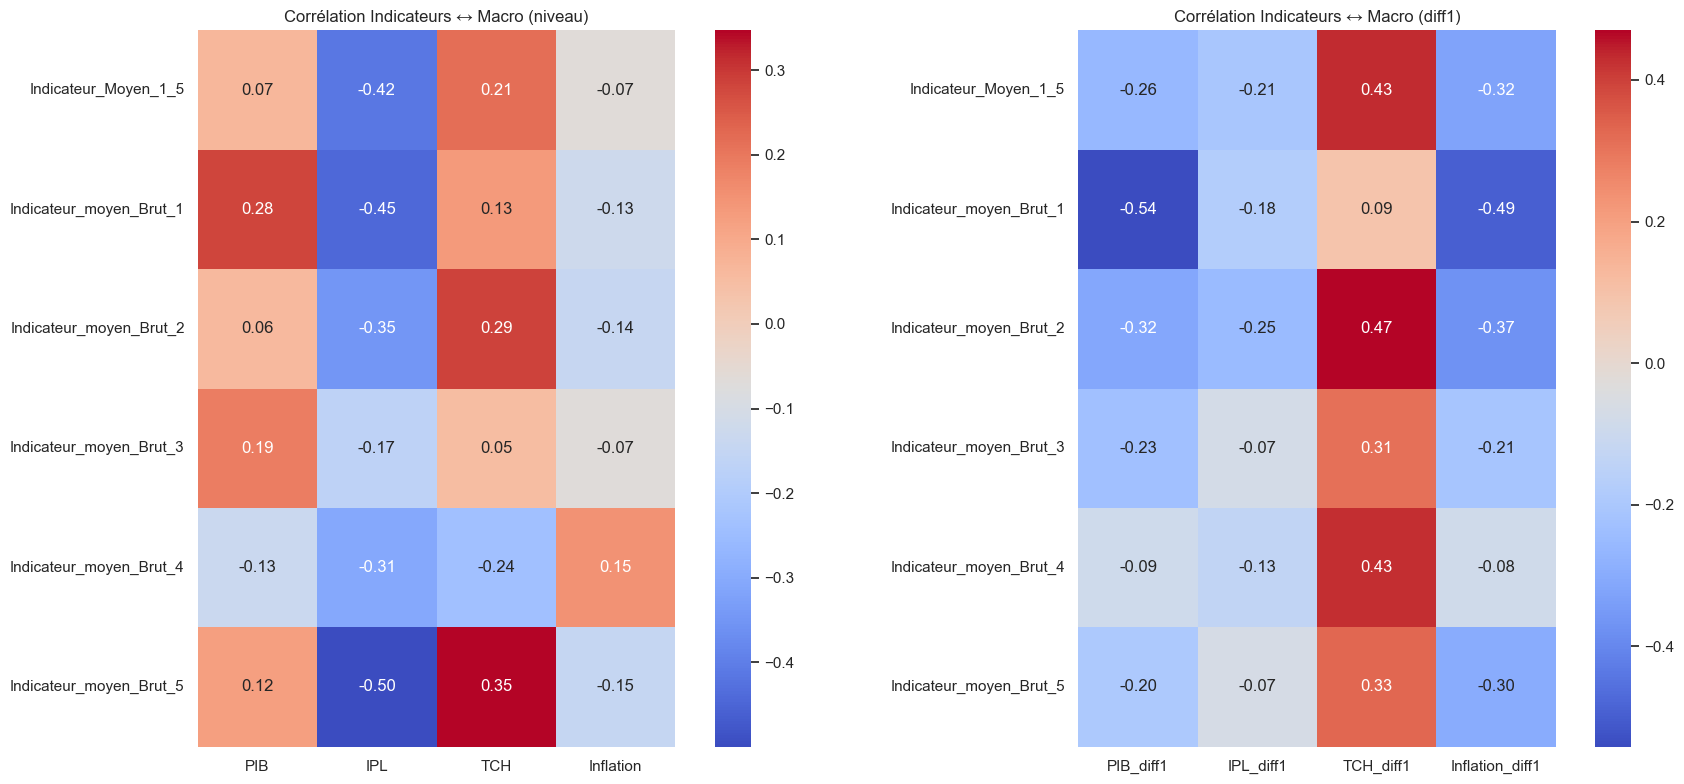

In [160]:
# Sélectionner uniquement les colonnes "Indicateur" et variables macro (niveau + diff1)
cols_indicateur = [col for col in df_merged.columns if col.startswith("Indicateur")]
cols_macro = ["PIB", "IPL", "TCH", "Inflation"]
cols_macro_diff = ["PIB_diff1", "IPL_diff1", "TCH_diff1", "Inflation_diff1"]

# Corrélation entre Indicateurs et valeurs macro
correlation_macro = df_merged[cols_indicateur + cols_macro].corr().loc[cols_indicateur, cols_macro]

# Corrélation entre Indicateurs et variations macro (diff1)
correlation_macro_diff = df_merged[cols_indicateur + cols_macro_diff].corr().loc[cols_indicateur, cols_macro_diff]

# Tracer les deux heatmaps sur des subplots côte à côte
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Corrélation macro niveau
sns.heatmap(correlation_macro, annot=True, fmt=".2f", cmap="coolwarm", square=True, ax=axes[0])
axes[0].set_title("Corrélation Indicateurs ↔ Macro (niveau)")

# Corrélation macro variations (diff1)
sns.heatmap(correlation_macro_diff, annot=True, fmt=".2f", cmap="coolwarm", square=True, ax=axes[1])
axes[1].set_title("Corrélation Indicateurs ↔ Macro (diff1)")

plt.tight_layout()
plt.show()


## WTF

le segment 6 est constant ?? + suppérieur à 1

il a tendance à augmenter l'indicateur global (make sense)

/var/folders/f0/q3pz9yqx3x7gnp3hqnj1hqvm0000gn/T/ipykernel_2058/3203460429.py:10: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_annual = df_global.set_index('date').resample('A').mean(numeric_only=True)


,Occurrences,count
0,3 days,45
1,356 days,11
2,357 days,3


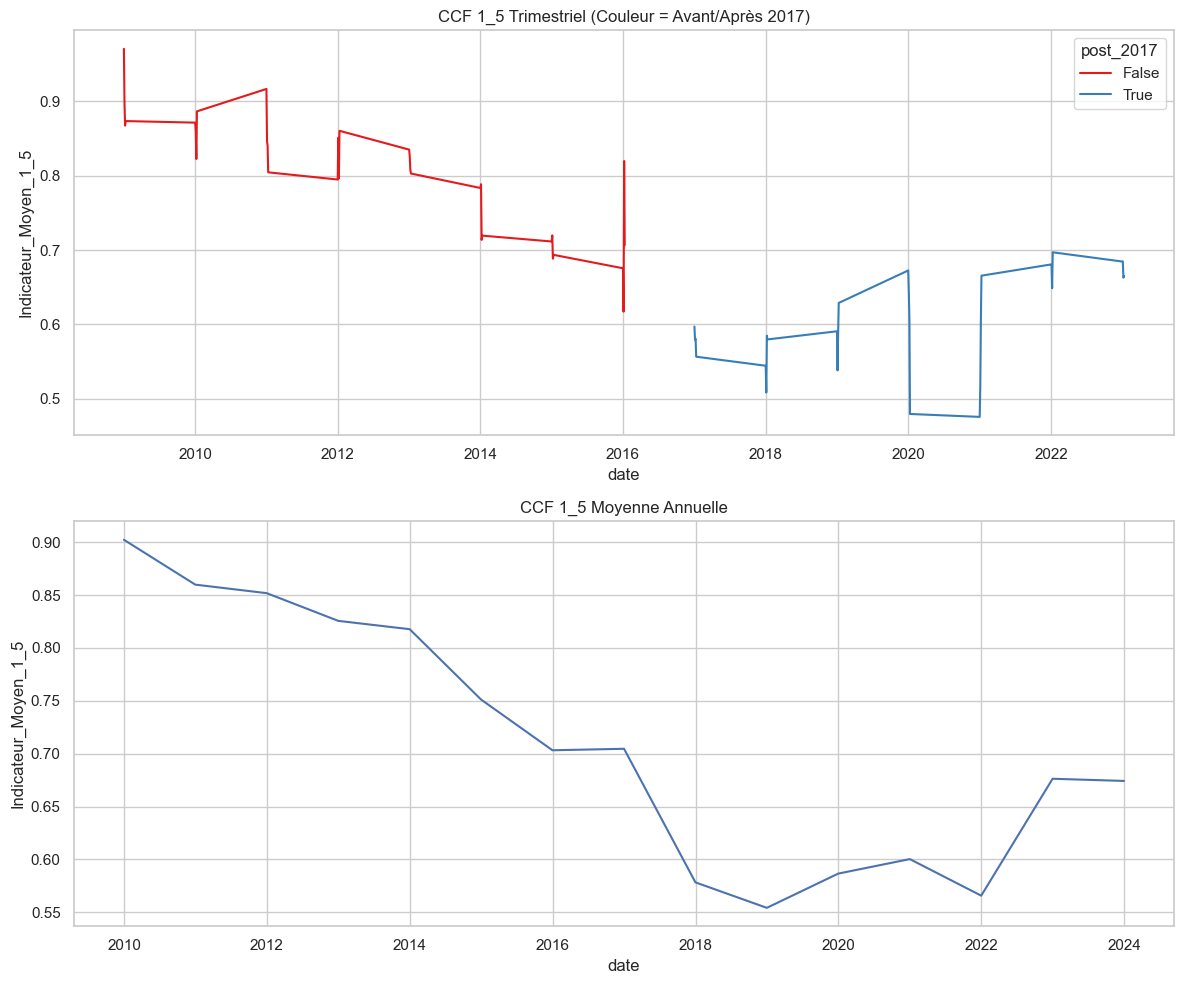

In [21]:
# Vérification de la fréquence réelle (différence entre dates)
df_global['delta'] = df_global['date'].diff()
freq_counts = df_global['delta'].value_counts()

# Ajout d'une colonne année pour repérage du changement de régime
df_global['year'] = df_global['date'].dt.year
df_global['post_2017'] = df_global['year'] >= 2017

# Résumé annuel (moyenne annuelle)
df_annual = df_global.set_index('date').resample('A').mean(numeric_only=True)

# Tracer les séries trimestrielles et annuelles
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=False)

# Trimestriel
sns.lineplot(data=df_global, x='date', y='Indicateur_Moyen_1_5', hue='post_2017', palette='Set1', ax=axs[0])
axs[0].set_title("CCF 1_5 Trimestriel (Couleur = Avant/Après 2017)")

# Annuel
sns.lineplot(data=df_annual, x=df_annual.index, y='Indicateur_Moyen_1_5', ax=axs[1])
axs[1].set_title("CCF 1_5 Moyenne Annuelle")
axs[1].set_ylabel("Indicateur_Moyen_1_5")

plt.tight_layout()

# Affichage des résultats de la granularité temporelle
display(freq_counts.reset_index().rename(columns={'index': 'Intervalle', 'delta': 'Occurrences'}))
